# SAT

In [1]:
!pip3 install z3-solver

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
from itertools import combinations
from z3 import *
import utils 
import math
import time
import os
from tqdm import tqdm
import numpy as np
from sat_utils import *

In [3]:
OVERRIDE = False

## Defining solvers

In [4]:
class SATSolver:

    def __init__(self, timeout = None):
        self.solver = Solver()
        if timeout != None:
            self.solver.set(timeout= timeout * 1000)

    def add_constraint(self, constraint):
        self.solver.add(constraint)

    def solve(self):
        return self.solver.check()

    def get_model(self):
        return self.solver.model()

In [5]:
from re import S


class VLSISolver:

    def __init__(self, plate_width, n_chips, chips_widths, chips_heights, rotation, symmetry_breaking, time_available, interrupt):
        self.plate_width = plate_width
        self.n_chips = n_chips
        self.chips_widths = chips_widths
        self.chips_heights = chips_heights
        self.rotation = rotation
        self.symmetry_breaking = symmetry_breaking  
        self.time_available = time_available
        self.interrupt = interrupt

        self.min_height = math.ceil(np.sum(chips_widths * chips_heights) / plate_width)
        self.max_height = np.sum([min(h, w) for h, w in zip(chips_heights, chips_widths)]) if rotation else np.sum(chips_heights)

        self.solved = False
        self.plate = None
        self.rotated = None
        self.plate_height = None
        self.solving_time = None
        self.solver = None

    def solve(self):
        start_time = time.time()

        for plate_height in range(self.min_height, self.max_height):
            time_remained = self.time_available - (time.time() - start_time)
            if time_remained <= 0:
                break

            # Defining SATSolver
            if self.interrupt:
                self.solver = SATSolver(timeout=int(time_remained))
            else:
                self.solver = SATSolver()


            # Defining variables
            self.plate = [[[Bool(f"x_{k}_{j}_{i}") for i in range(self.n_chips)] for j in range(self.plate_width)] for k in range(plate_height)]
            self.rotated = [Bool(f"r_{k}") for k in range(self.n_chips)]
            self.plate_height = plate_height

            # Defining constraints:
            # - 1° constraint 
            overlapping_check = []
            for row in self.plate:
                for point in row:
                    overlapping_check = overlapping_check + at_most_one(point)

            # - 2° constraint
            placing_check = []
            for k in range(self.n_chips):

                configurations = []
                for y in range(plate_height - self.chips_heights[k] + 1):
                    for x in range(self.plate_width - self.chips_widths[k] + 1):
                        configurations.append(all_true([self.plate[y + slide_y][x + slide_x][k] for slide_x in range(self.chips_widths[k]) for slide_y in range(self.chips_heights[k])]))
                
                # If chips can be rotated...
                if self.rotation:
                    configurations_r = []
                    for y in range(plate_height - self.chips_widths[k] + 1):
                        for x in range(self.plate_width - self.chips_heights[k] + 1):
                            configurations_r.append(all_true([self.plate[y + slide_y][x + slide_x][k] for slide_x in range(self.chips_heights[k]) for slide_y in range(self.chips_widths[k])]))
                
                    placing_check = placing_check + exactly_one([
                        And(exactly_one(configurations) + [Not(self.rotated[k])]),
                        And(exactly_one(configurations_r) + [self.rotated[k]])
                    ]) 
                # Otherwise...
                else:
                    placing_check = placing_check + exactly_one(configurations)

            # - 3° constraint 
            if self.symmetry_breaking: 
                symmetry_breaking = []
                symmetry_breaking = [z3_lex_less_eq([self.plate[i][j] for j in range(self.plate_width) for i in range(plate_height)],
                                    [self.plate[i][j] for j in range(self.plate_width) for i in reversed(range(plate_height))], self.n_chips)]
                symmetry_breaking += [z3_lex_less_eq([self.plate[i][j] for j in range(self.plate_width) for i in range(plate_height)],
                                    [self.plate[i][j] for j in reversed(range(self.plate_width)) for i in range(plate_height)], self.n_chips)]
                symmetry_breaking += [z3_lex_less_eq([self.plate[i][j] for j in range(self.plate_width) for i in range(plate_height)],
                                    [self.plate[i][j] for j in reversed(range(self.plate_width)) for i in reversed(range(plate_height))], self.n_chips)]
            
            # Add constraints
            self.solver.add_constraint(overlapping_check)
            self.solver.add_constraint(placing_check)
            if self.symmetry_breaking: # Only if symmetry breaking is applied!
                self.solver.add_constraint(symmetry_breaking)

            if self.solver.solve() == sat:
                self.solving_time = time.time() - start_time
                self.solved = True
                return True
            

        self.solving_time = time.time() - start_time
        self.solved = False
        return False

    def evalutate(self):
        model = self.solver.get_model()
    
        circuits_pos = []
        for k in range(self.n_chips):
            found = False
            for x in range(self.plate_height):
                for y in range(self.plate_width):
                    if not found and model.evaluate(self.plate[x][y][k]):
                        if self.rotation:
                            if model.evaluate(self.rotated[k]):
                                circuits_pos.append((y, x, self.chips_heights[k], self.chips_widths[k]))
                            else:
                                circuits_pos.append((y, x, self.chips_widths[k], self.chips_heights[k]))
                        else:
                            circuits_pos.append((y, x, self.chips_widths[k], self.chips_heights[k]))
                        found = True

        pos_x = [x for x, _, _, _ in circuits_pos]
        pos_y = [y for _, y, _, _ in circuits_pos]
        chips_w_a = [w for _, _, w, _ in circuits_pos]
        chips_h_a = [h for _, _, _, h in circuits_pos]

        return pos_x, pos_y, chips_w_a, chips_h_a, self.plate_width, self.plate_height, self.solving_time

    def __str__(self):
        output = f'Time available: {self.time_available}\nMin height: {self.min_height}\nMax height: {self.max_height}\n\nWidth of the plate: {self.plate_width}\nNumber of chips: {self.n_chips}\n\n'
        for i in range(self.n_chips):
            output += f'Size of {i}° chip: ({self.chips_widths[i]}, {self.chips_heights[i]})\n' 
        return output 

## Solve problems

In [6]:
NUMBER_OF_INSTANCES = 40
TIME_AVAILABLE = 300

In [7]:
def solve(rotation, symmetry_breaking, interrupt):

    NAME = ('rot_' if rotation else 'not_rot_') + ('sb' if symmetry_breaking else 'not_sb')

    OUT_DIRECTORY_PATH = './out/' + NAME + '/'
    IMG_DIRECTORY_PATH = './img/' + NAME + '/'
    STATS_PATH = './stats/' + NAME + '.csv'

    os.makedirs(OUT_DIRECTORY_PATH, exist_ok=True)
    os.makedirs(IMG_DIRECTORY_PATH, exist_ok=True)
    
    for i in range(NUMBER_OF_INSTANCES):

        OUT_FILE_PATH = OUT_DIRECTORY_PATH + str(i+1) + '.txt'
        IMG_FILE_PATH = IMG_DIRECTORY_PATH + str(i+1) + '.jpg'
        
        print(f'Instance number: {str(i)}')

        if not os.path.exists(OUT_FILE_PATH) or not os.path.exists(IMG_FILE_PATH) or OVERRIDE:
            print('Computing solution...')
            # Load instance
            plate_width, n_chips, chips_widths, chips_heights = utils.load_data(i + 1)

            # Solve instance
            vlsi_solver = VLSISolver(plate_width, 
                                    n_chips, 
                                    chips_widths, 
                                    chips_heights, 
                                    rotation = rotation, 
                                    symmetry_breaking = symmetry_breaking,
                                    time_available = TIME_AVAILABLE,
                                    interrupt = interrupt)
            is_solved = vlsi_solver.solve()
            
            # Print results
            print(f'Problem solved? {is_solved}')
            print(f'Time required: {vlsi_solver.solving_time} seconds')

            if is_solved:

                # Evaluate the solution
                pos_x, pos_y, chips_w_a, chips_h_a, plate_width, plate_height, solving_time = vlsi_solver.evalutate()
                
                # Print solution
                utils.plot_device(pos_x, pos_y, chips_w_a, chips_h_a, plate_width, plate_height)
                
                # Save results
                utils.plot_device(pos_x, pos_y, chips_w_a, chips_h_a, plate_width, plate_height, IMG_FILE_PATH)
                utils.write_sol(OUT_FILE_PATH, 
                                plate_width, 
                                plate_height, 
                                n_chips, 
                                chips_widths, 
                                chips_heights, 
                                pos_x, 
                                pos_y)
                utils.write_stat_line(STATS_PATH, 
                                    i, 
                                    solving_time)
            
            else:
                utils.write_error(OUT_FILE_PATH)
                utils.write_stat_line(STATS_PATH,
                                      i,
                                      -1)


        else:
            print('Loading solution...')

            # Load results
            try:
                plate_width, plate_height, n_chips, chips_w_a, chips_h_a, pos_x, pos_y = utils.load_sol(OUT_FILE_PATH)
                stats = utils.load_stats(STATS_PATH)
            
                # Print solution
                print(f'Time required: {stats.at[i, "time"]} seconds')
                utils.plot_device(pos_x, pos_y, chips_w_a, chips_h_a, plate_width, plate_height)
            except OSError:
                print(f'Time exceeded!')
                
            
            

            

### Without rotation and without symmetry breaking

In [8]:
ROTATION = False
SYMMETRY_BREAKING = False

INTERRUPT = False

Instance number: 0
Loading solution...
Time required: 0.2374765872955322 seconds


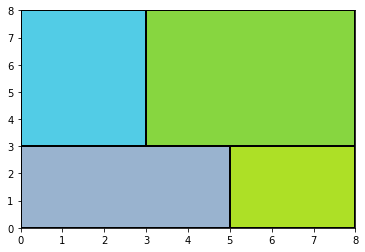

Instance number: 1
Loading solution...
Time required: 0.4698567390441894 seconds


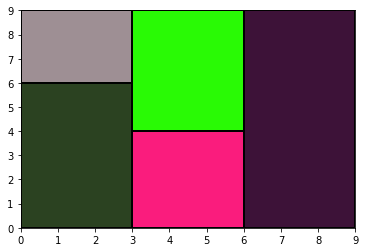

Instance number: 2
Loading solution...
Time required: 0.9711980819702148 seconds


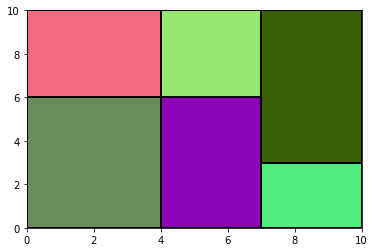

Instance number: 3
Loading solution...
Time required: 2.6311776638031006 seconds


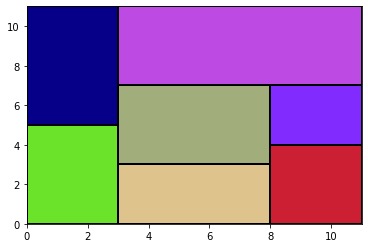

Instance number: 4
Loading solution...
Time required: 3.687833070755005 seconds


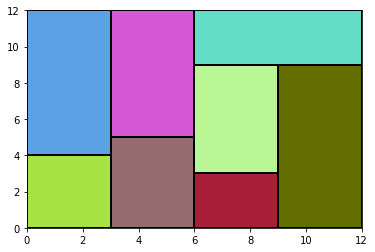

Instance number: 5
Loading solution...
Time required: 6.440051794052124 seconds


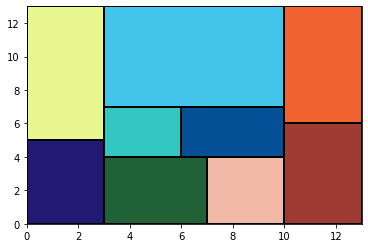

Instance number: 6
Loading solution...
Time required: 6.600411653518677 seconds


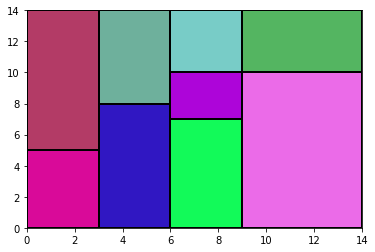

Instance number: 7
Loading solution...
Time required: 10.464125156402588 seconds


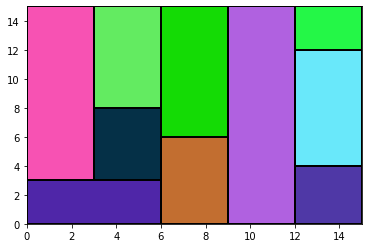

Instance number: 8
Loading solution...
Time required: 14.292710065841677 seconds


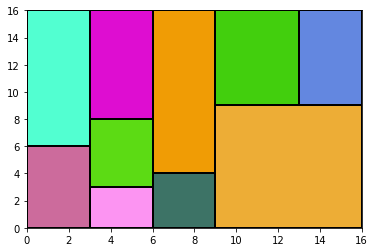

Instance number: 9
Loading solution...
Time required: 23.752414226531982 seconds


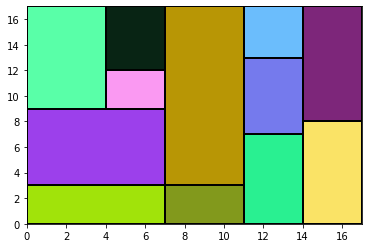

Instance number: 10
Loading solution...
Time required: 217.61342453956604 seconds


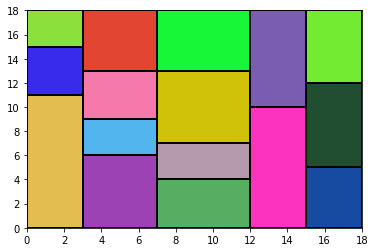

Instance number: 11
Loading solution...
Time required: 281.7079145908356 seconds


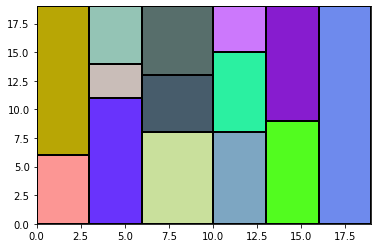

Instance number: 12
Loading solution...
Time required: 115.0432062149048 seconds


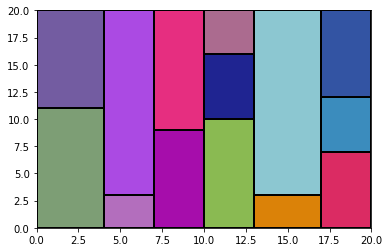

Instance number: 13
Loading solution...
Time required: 412.4419059753418 seconds


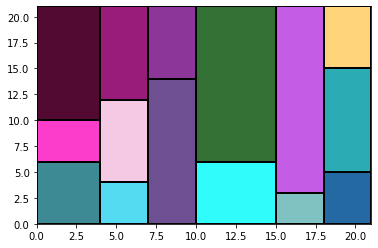

Instance number: 14
Loading solution...
Time required: 490.29599714279175 seconds


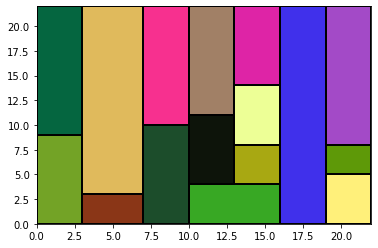

Instance number: 15
Computing solution...
Problem solved? True
Time required: 199.4993815422058 seconds


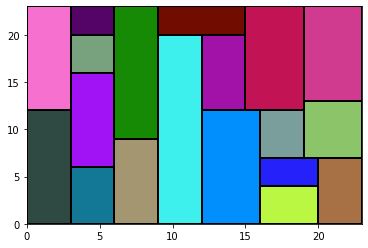

Instance number: 16
Computing solution...
Problem solved? True
Time required: 178.18179154396057 seconds


<Figure size 432x288 with 0 Axes>

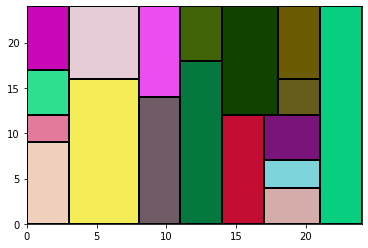

Instance number: 17
Computing solution...


In [ ]:
solve(ROTATION, SYMMETRY_BREAKING, INTERRUPT)

### With rotation and without symmetry breaking

In [ ]:
ROTATION = True
SYMMETRY_BREAKING = False

INTERRUPT = False

In [ ]:
solve(ROTATION, SYMMETRY_BREAKING, INTERRUPT)

### Without rotation and with symmetry breaking

In [ ]:
ROTATION = False
SYMMETRY_BREAKING = False

INTERRUPT = False

In [ ]:
solve(ROTATION, SYMMETRY_BREAKING, INTERRUPT)

### With rotation and with symmetry breaking

In [ ]:
ROTATION = True
SYMMETRY_BREAKING = True

INTERRUPT = False

In [ ]:
solve(ROTATION, SYMMETRY_BREAKING, INTERRUPT)